In [1]:
library(tidyverse)
players <- read_csv("players (1).csv")
sessions <- read_csv("sessions (2).csv")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimite

In [2]:
dim(players)
dim(sessions)

[1] 196   7

[1] 1535    5

<h3>1. Data Description</h3>

This project uses data collected from a Minecraft research server designed to study player behaviour. Two datasets are provided: players.csv, which contains demographic and background information about each player, and sessions.csv, which records gameplay sessions for those players. When merged, these datasets allow analysis of how demographic and behavioural characteristics relate to newsletter subscription.


**players.csv**

This dataset contains one row per unique player.

Number of observations: 196

Number of variables: 7


| Variable Name   | Type      | Meaning                                       |
|-----------------|-----------|-----------------------------------------------|
| experience      | character | Player’s self-reported skill level            |
| subscribe       | logical   | Whether the player subscribed (TRUE/FALSE)    |
| hashedEmail     | character | Anonymous unique player identifier            |
| played_hours    | numeric   | Total Minecraft hours played                  |
| name            | character | Player name                      |
| gender          | character | Player gender                                 |
| Age             | numeric   | Player age    

**sessions.csv**
This dataset contains one row per gameplay session. A single player may have many sessions.

Number of observations: 1535

Number of variables: 5

| Variable Name         | Type      | Meaning                                  |
|-----------------------|-----------|------------------------------------------|
| hashedEmail           | character | Links session to player                  |
| start_time            | datetime  | Session start                            |
| end_time              | datetime  | Session end                              |
| original_start_time   | datetime  | Original logged start time               |
| original_end_time     | datetime  | Original logged end time                 |


**Data Issues**

Missing age values for some players

Players with no recorded sessions → NA after merging

Some sessions have extremely long durations (possible idle time)

Newsletter subscription is imbalanced (few 1’s)

Behaviour data may not reflect true engagement (AFK)

Time zone differences may influence session timing

Data collected passively, so players are self-selected

In [3]:
players %>% summarise(across(where(is.numeric), ~ round(mean(.x, na.rm = TRUE), 2)))

played_hours,Age
<dbl>,<dbl>
5.85,21.14


<h3>2. Questions</h3>

**Broad Question**:
What player characteristics and behaviours are predictive of newsletter subscription?

**Specific Question**:
Does average session length and age predict whether a player subscribes to the newsletter?

Newsletter subscription is a binary variable, so it can be modeled with classification methods such as logistic regression. Age is available directly in the players dataset, while average session length can be computed from the sessions dataset by subtracting start_time from end_time and averaging session durations for each player. Merging these datasets through hashed_email produces a single player-level table that combines demographic and behavioural information, which is required to model newsletter subscription.

<h3>3.Exploratory Data Analysis and Visualization </h3>

In [4]:
sessions_clean <- sessions %>%
  mutate(
    start_time = as.POSIXct(start_time, format="%d/%m/%Y %H:%M"),
    end_time   = as.POSIXct(end_time,   format="%d/%m/%Y %H:%M"),
    session_length = as.numeric(end_time - start_time)
  ) %>%
  filter(session_length > 0, session_length < 60*60*8) %>%
  group_by(hashedEmail) %>%
  summarise(avg_session_length = mean(session_length, na.rm = TRUE))

analysis_df <- players %>%
  left_join(sessions_clean, by = "hashedEmail")
analysis_df

In [6]:
players %>%
  summarise(across(where(is.numeric), ~ round(mean(.x, na.rm = TRUE), 2)))

played_hours,Age
<dbl>,<dbl>
5.85,21.14


Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


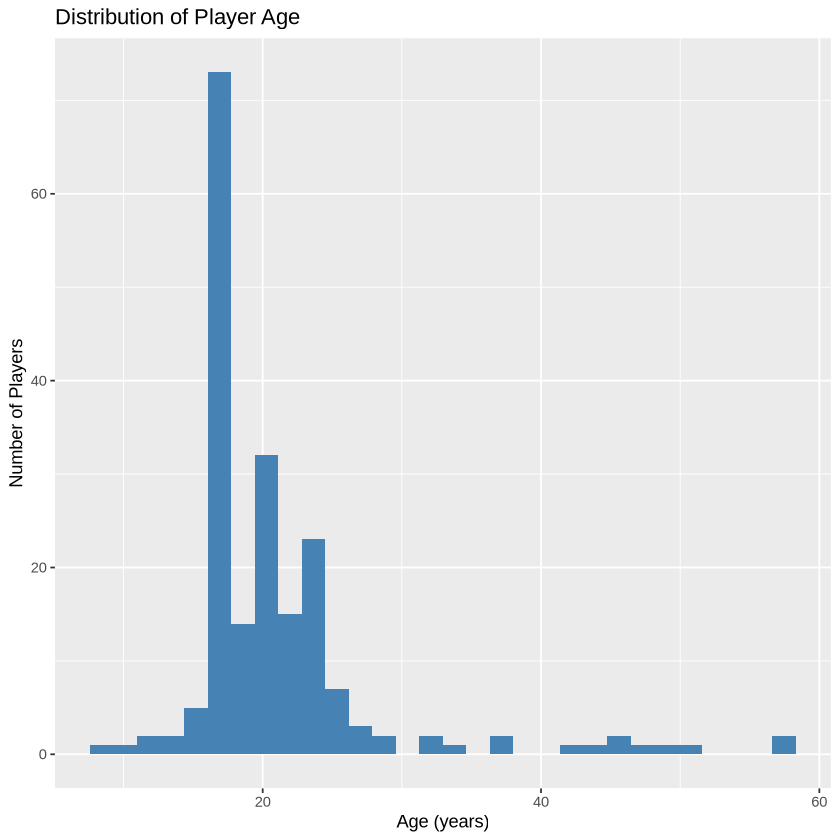

In [11]:
ggplot(analysis_df, aes(Age)) +
  geom_histogram(bins = 30, fill = "steelblue") +
  labs(title="Distribution of Player Age",
       x="Age (years)",
       y="Number of Players")

Warning message:
“Removed 71 rows containing non-finite outside the scale range (`stat_bin()`).”


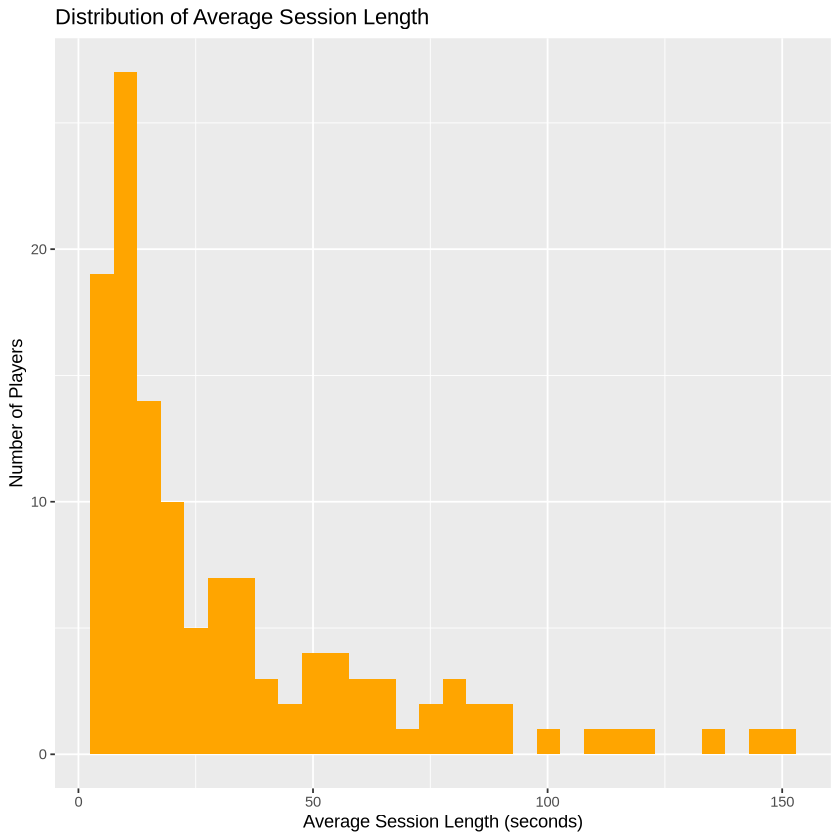

In [8]:
ggplot(analysis_df, aes(avg_session_length)) +
  geom_histogram(bins = 30, fill="orange") +
  labs(title="Distribution of Average Session Length",
       x="Average Session Length (seconds)",
       y="Number of Players")

Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


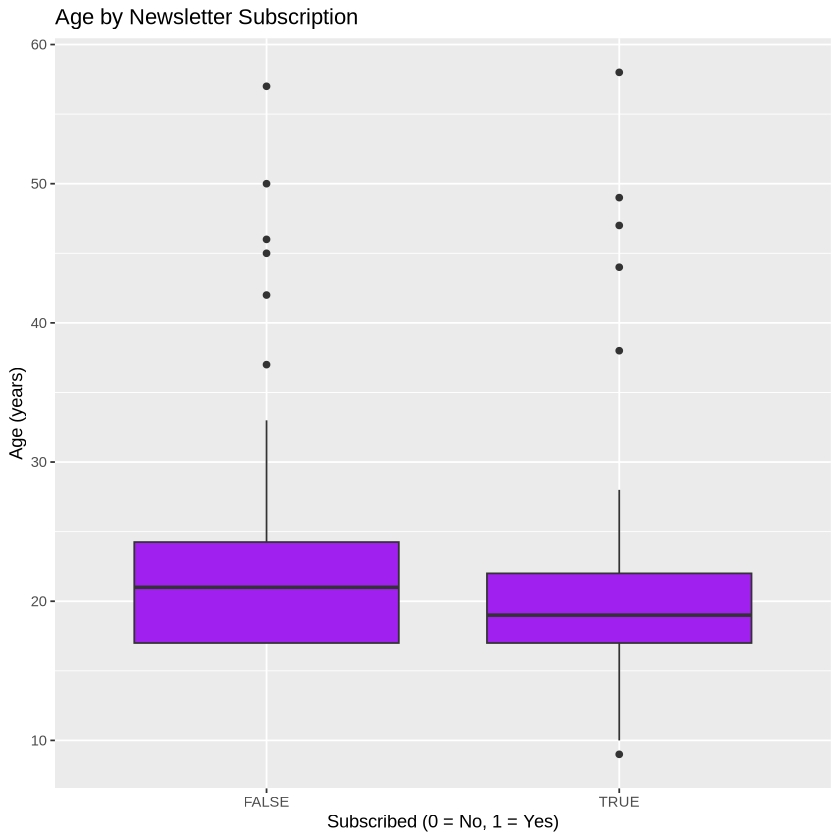

In [9]:
ggplot(analysis_df, aes(x=factor(subscribe), y=Age)) +
  geom_boxplot(fill="purple") +
  labs(title="Age by Newsletter Subscription",
       x="Subscribed (0 = No, 1 = Yes)",
       y="Age (years)")


Warning message:
“Removed 71 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


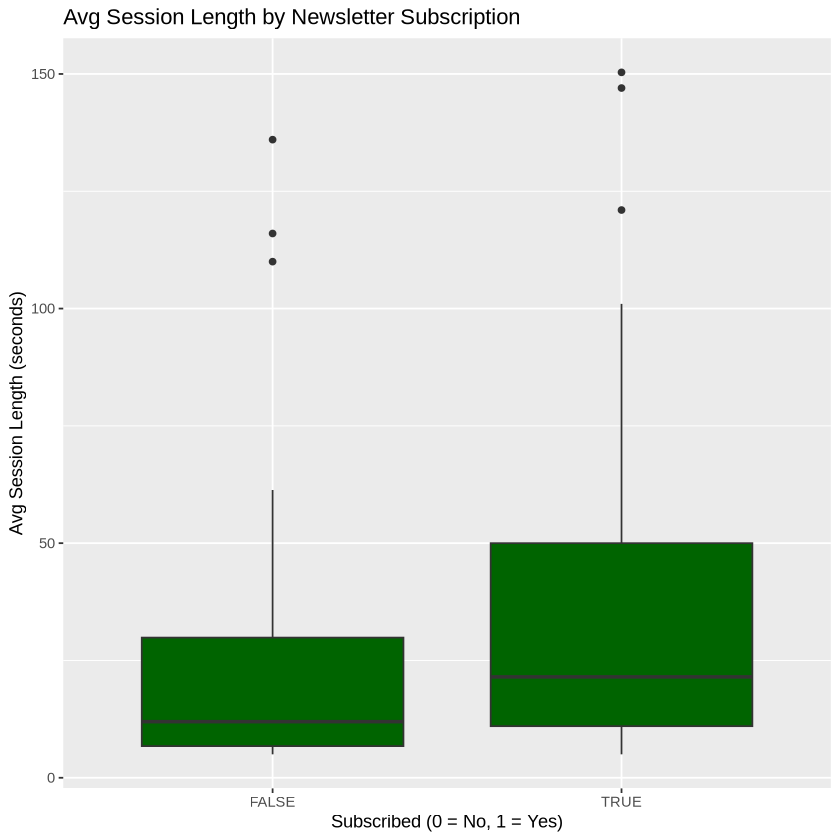

In [10]:
ggplot(analysis_df, aes(x=factor(subscribe), y=avg_session_length)) +
  geom_boxplot(fill="darkgreen") +
  labs(title="Avg Session Length by Newsletter Subscription",
       x="Subscribed (0 = No, 1 = Yes)",
       y="Avg Session Length (seconds)")


The age distribution shows that most players are between 17 and 22 years old, with only a few older outliers. This narrow range suggests that age may have limited predictive value, since most players fall within the same group.

Average session length is highly right-skewed. Most players have short sessions, while a smaller subset has much longer average durations. These long values may reflect high engagement or idle time. The skew indicates that this variable may require transformation or careful handling during modelling, but it also appears to contain meaningful behavioural information.

Comparing subscribers and non-subscribers reveals that age differs very little between the two groups, reinforcing that age is unlikely to be a strong predictor. In contrast, subscribers show noticeably longer average session lengths, suggesting that engaged players are more likely to opt into the newsletter.

Overall, behavioural variables appear more informative than demographic ones for predicting subscription.

<h3>4. Methods and Planning</h3>

To address my question about whether age and average session length can predict newsletter subscription, I plan to use logistic regression. This method is appropriate because the response variable, subscribe, is binary, and logistic regression models the probability of an outcome based on one or more explanatory variables. It is also one of the core classification techniques taught in this course and provides interpretable coefficients, which helps determine how each predictor contributes to subscription likelihood.

Logistic regression requires several assumptions: observations should be independent, the relationship between predictors and the log-odds of the outcome should be approximately linear, and predictors should not exhibit severe multicollinearity. These assumptions are reasonable for this dataset because each player is an independent unit, and the predictors (Age and average session length) measure distinct characteristics.

However, the method has limitations. Logistic regression can be sensitive to outliers, which may be an issue because average session length is skewed. It also may not capture nonlinear patterns unless transformations are applied. In addition, the dataset shows class imbalance, with far fewer subscribers than non-subscribers, which could affect classification performance.

To compare and select the model, I will use a train–test split followed by cross-validation. Specifically, I plan to split the data into 75% training and 25% testing. Cross-validation (such as 5-fold CV) will be applied on the training set to evaluate model stability and tune any preprocessing decisions. Model performance will be compared using metrics such as accuracy, ROC AUC, and classification error. The final model will then be evaluated on the test set to assess generalization.

Before modelling, I will ensure the dataset is processed consistently by removing unrealistic session durations, handling missing values, and confirming that all variables are in appropriate numeric or categorical formats.

<h3>5. GitHub Repository</h3>

The GitHub repository for my DSCI 100 Individual Planning Report is available here:

https://github.com/isabelleyan0921-code/Iyan.git